# 一个小目标 mission one
---


## 任务
使用 逻辑回归 对客户逾期情况进行建模，预测用户是否会逾期


In [76]:
# 导入需要的包
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from matplotlib import pyplot as plt

# 设置 pandas 显示列数
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

## 1. 导入数据

In [12]:
# 因为数据并非utf-8编码，要使用gbk编码读入，否则出错
data = pd.read_csv('./data/data.csv', index_col=0, encoding='gbk')

# 观察数据构成
data.head()

,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,source,first_transaction_day,trans_day_last_12_month,id_name,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,NaN,19890,0,30.0,20130817.0,149050,151.0,0.40,34030,7.0,3920,0.15,1020,0.55,一线城市,4.0,19.0,4.0,19.0,1.0,1.0,2.0,2.0,5.0,2170,6.0,0.0,1970,18040,0.0,1,xs,1738.0,85.0,蒋红,583.0,79.0,8.0,2.0,6.0,10.0,2018-04-25,2.0,5.0,8.0,552.0,73.0,37.0,34.0,2.0,10.0,1.0,9.0,1.0,1.0,13.0,37.0,7.0,1.0,0.0,341.0,2018-04-19,2200.0,72.0,9.0,10.0,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,1.0,16970,0,23.0,20160402.0,302910,224.0,0.35,10590,5.0,6950,0.05,1210,0.50,一线城市,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100,9.0,0.0,1820,15680,0.0,0,xs,779.0,84.0,崔向朝,653.0,73.0,7.0,4.0,2.0,8.0,2018-05-03,2.0,6.0,8.0,635.0,76.0,37.0,36.0,0.0,17.0,5.0,12.0,2.0,2.0,8.0,49.0,4.0,2.0,1.0,353.0,2018-05-05,2000.0,74.0,12.0,12.0,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,NaN,9710,0,9.0,20170617.0,11520,31.0,1.00,5710,5.0,840,0.65,570,0.65,一线城市,0.0,68.0,0.0,68.0,0.0,3.0,6.0,6.0,0.0,0,3.0,0.0,0,0,0.0,1,xs,338.0,95.0,王中云,654.0,76.0,11.0,5.0,5.0,16.0,2018-05-05,5.0,5.0,14.0,633.0,83.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,157.0,2018-05-01,1500.0,77.0,2.0,2.0,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,NaN,6210,0,33.0,20130516.0,491130,360.0,0.15,91690,7.0,46850,0.05,1290,0.45,三线城市,6.0,8.0,6.0,8.0,0.0,1.0,8.0,8.0,31700.0,8140,9.0,0.0,2700,27970,0.0,0,xs,1831.0,82.0,何洋洋,595.0,79.0,12.0,7.0,4.0,22.0,2018-05-05,3.0,16.0,17.0,542.0,75.0,85.0,81.0,4.0,22.0,5.0,17.0,2.0,4.0,34.0,91.0,26.0,2.0,0.0,355.0,2018-05-03,1800.0,74.0,17.0,18.0,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,NaN,11150,0,12.0,20

In [55]:
# 划分 X, y
y = data['status']
X = data.drop('status', axis=1)

# X行数
print('X.shape:', X.shape)
print('y 的分布\n', y.value_counts())

X.shape: (4754, 88)
y 的分布
 0    3561
1    1193
Name: status, dtype: int64


## 2. 数据探索及特征处理
本次任务目的在于主流程，所以数据探索部分做得比较粗糙，以后有需要再慢慢补充
从上面数据看出，本份数据以数值型特征位数，有少数几个字符型特征，还有两个日期特征。下面一步步进行处理

In [56]:
# 首先剔除一些明显无用的特征，如 id_name, custid, trade_no, bank_card_no，
# 这些优点类似一个人的唯一信息，如果加入模型训练且对最终模型生效的话，很可能就是出现了过拟合
X.drop(['id_name', 'custid', 'trade_no', 'bank_card_no'], axis=1, inplace=True)
print(X.shape)

(4754, 84)


### 数值型变量

In [57]:
# 选取数值型特征
X_num = X.select_dtypes('number').copy()
print(X_num.shape)
# 查看缺失情况
num_miss_rate = 1 - X_num.count() / len(X_num)
num_miss_rate.sort_values(ascending=False)

(4754, 80)


student_feature                               0.630627
cross_consume_count_last_1_month              0.089609
latest_three_month_apply                      0.063946
query_finance_count                           0.063946
latest_six_month_apply                        0.063946
latest_one_month_apply                        0.063946
query_cash_count                              0.063946
query_sum_count                               0.063946
query_org_count                               0.063946
apply_credibility                             0.063946
apply_score                                   0.063946
latest_query_day                              0.063946
latest_one_month_loan                         0.062474
loans_score                                   0.062474
loans_credibility_behavior                    0.062474
loans_count                                   0.062474
loans_settle_count                            0.062474
loans_overdue_count                           0.062474
loans_org_

从缺失情况看出，数值型变量除了 student_feature 缺失比较高之外，其他均在 10% 以下。对此，

针对 student_feature 我们需要观察一下特征情况，对于其他缺失值，我们尝试用均值代替。

理论上做完缺失值填充之后，还在进行特征筛选，但这不是本次任务重点，就先略过了。

In [58]:
# student_feature
print(X_num['student_feature'].value_counts())
# 使用一个另外的值代替缺失值，如 0
X_num.fillna({'student_feature': 0}, inplace=True)
# 观察填充后情况
print(X_num['student_feature'].value_counts())

1.0    1754
2.0       2
Name: student_feature, dtype: int64
0.0    2998
1.0    1754
2.0       2
Name: student_feature, dtype: int64


In [59]:
# 其他数值型变量使用均值代替
X_num.fillna(X_num.mean(), inplace=True)

### 字符型变量
显然，在字符型变量中，source只有一个值，无意义。而 latest_query_time 和 loans_latest_time 属于日期格式，因不知具体业务逻辑，故直接删除。

最后只剩 reg_preference_for_trad，对其进行 缺失值填充（众数） 后，直接转换成哑变量

In [60]:
X_str = X.select_dtypes(exclude='number').copy()
X_str.describe()

,reg_preference_for_trad,source,latest_query_time,loans_latest_time
count,4752,4754,4450,4457
unique,5,1,207,232
top,一线城市,xs,2018-04-14,2018-05-03
freq,3403,4754,423,134


In [61]:
X_str['reg_preference_for_trad'] = X_str['reg_preference_for_trad'].fillna(X_str['reg_preference_for_trad'].mode()[0])
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])
X_str_dummy.head()

,一线城市,三线城市,二线城市,其他城市,境外
5,1,0,0,0,0
10,1,0,0,0,0
12,1,0,0,0,0
13,0,1,0,0,0
14,1,0,0,0,0


In [62]:
X_cl = pd.concat([X_num, X_str_dummy], axis=1, sort=False)
X_cl.shape

(4754, 85)

### 3. 数据划分
三七 分，随机种子就取今天日期吧

In [63]:
random_state = 1115
X_train, X_test, y_train, y_test = train_test_split(X_cl, y, random_state=random_state)
print(X_train.shape)
print(X_test.shape)

(3565, 85)
(1189, 85)


### 4. 建模

In [69]:
# 先用网格搜索选下超参，
# 评价参数没有给出，这次使用 f1_micro 作为评价标准
lr = LogisticRegression()
param_grid = {
    'C': [0.05, 0.1, 0.5, 1, 5],
    'penalty': ['l1', 'l2']
}

grid = GridSearchCV(lr, param_grid=param_grid, scoring='f1_micro')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'C': 0.1, 'penalty': 'l1'}
0.791023842917


In [70]:
# 使用训练好的超参进行建模
lr = LogisticRegression(**grid.best_params_)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 5. 评估
用测试集对模型效果进行评估，主要使用 准确性，ks，auc，f1 等指标

In [71]:
# 准确性
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('准确性：')
print('训练集：{:.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('测试集：{:.4f}'.format(accuracy_score(y_test, y_test_pred)))

准确性：
训练集：0.8008
测试集：0.8007


In [72]:
# f1_score
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('准确性：')
print('训练集：{:.4f}'.format(f1_score(y_train, y_train_pred)))
print('测试集：{:.4f}'.format(f1_score(y_test, y_test_pred)))

准确性：
训练集：0.4662
测试集：0.4791


ROC AUC：
训练集：0.8073
测试集：0.7892
KS：
训练集：0.4600
测试集：0.4559


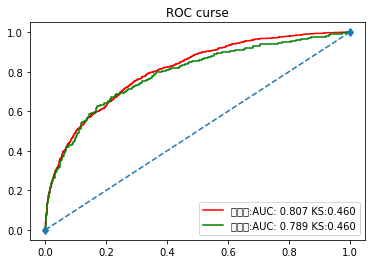

In [82]:
# roc_auc, ks
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_proba)
fpr_te, tpr_te, _ = roc_curve(y_test, y_test_proba)

print('ROC AUC：')
print('训练集：{:.4f}'.format(roc_auc_score(y_train, y_train_proba)))
print('测试集：{:.4f}'.format(roc_auc_score(y_test, y_test_proba)))

print('KS：')
print('训练集：{:.4f}'.format(max(abs((fpr_tr - tpr_tr)))))
print('测试集：{:.4f}'.format(max(abs((fpr_te - tpr_te)))))

# 绘图
plt.plot(fpr_tr, tpr_tr, 'r-',
         label="训练集:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_train, y_train_proba), max(abs((fpr_tr - tpr_tr)))))
plt.plot(fpr_te, tpr_te, 'g-',
         label="测试集:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_test, y_test_proba),
                                                 max(abs((fpr_tr - tpr_tr)))))
plt.plot([0, 1], [0, 1], 'd--')
plt.legend(loc='best')
plt.title("ROC curse")
plt.show()